## Imports

In [ ]:
import zipfile
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

## Extracting the `diabetes.csv` file

In [ ]:
# Dataset from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
zip_path = "/content/archive.zip"
extraction_path = "/content/diabetes_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

extracted_files = os.listdir(extraction_path)
extracted_files

['diabetes.csv']

In [ ]:
# Loading dataset
dataset_path = "/content/diabetes_dataset/diabetes.csv"
diabetes_data = pd.read_csv(dataset_path)

## Pre-processing and Data Preparation

In [ ]:
# Identify missing values and replace with NaN
diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = diabetes_data[
    ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = imputer.fit_transform(
    diabetes_data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']])

In [ ]:
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

## Baseline model

Best Perceptron Parameters: {'penalty': 'l2', 'max_iter': 3000, 'eta0': 0.1, 'class_weight': None, 'alpha': 0.0001}
Accuracy: 0.7077922077922078
Confusion Matrix:
 [[78 22]
 [23 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78       100
           1       0.58      0.57      0.58        54

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154



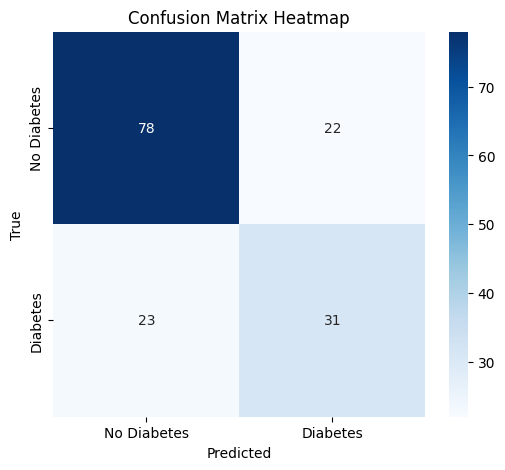

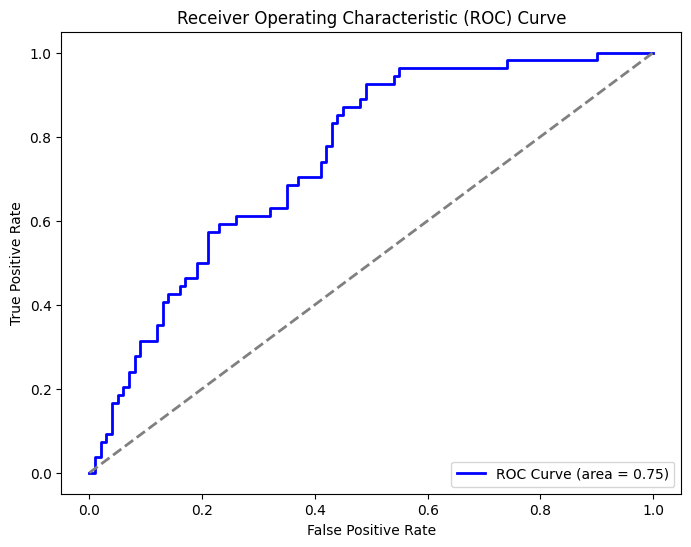

In [ ]:
# Splitinto training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for tuning
param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'max_iter': [1000, 2000, 3000],
    'eta0': [0.01, 0.1],
    'class_weight': [None, 'balanced']
}

# Initialize Perceptron and perform RandomizedSearchCV for parameter optimisation
perceptron = Perceptron(random_state=42)
random_search = RandomizedSearchCV(perceptron, param_grid, scoring='accuracy', n_iter=20, cv=StratifiedKFold(5), n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Find best Perceptron model & train
best_perceptron = random_search.best_estimator_
best_perceptron.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_perceptron.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Best Perceptron Parameters:", random_search.best_params_)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# ROC curve
y_pred_prob = best_perceptron.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Increasing accuracy with increased data visualisations

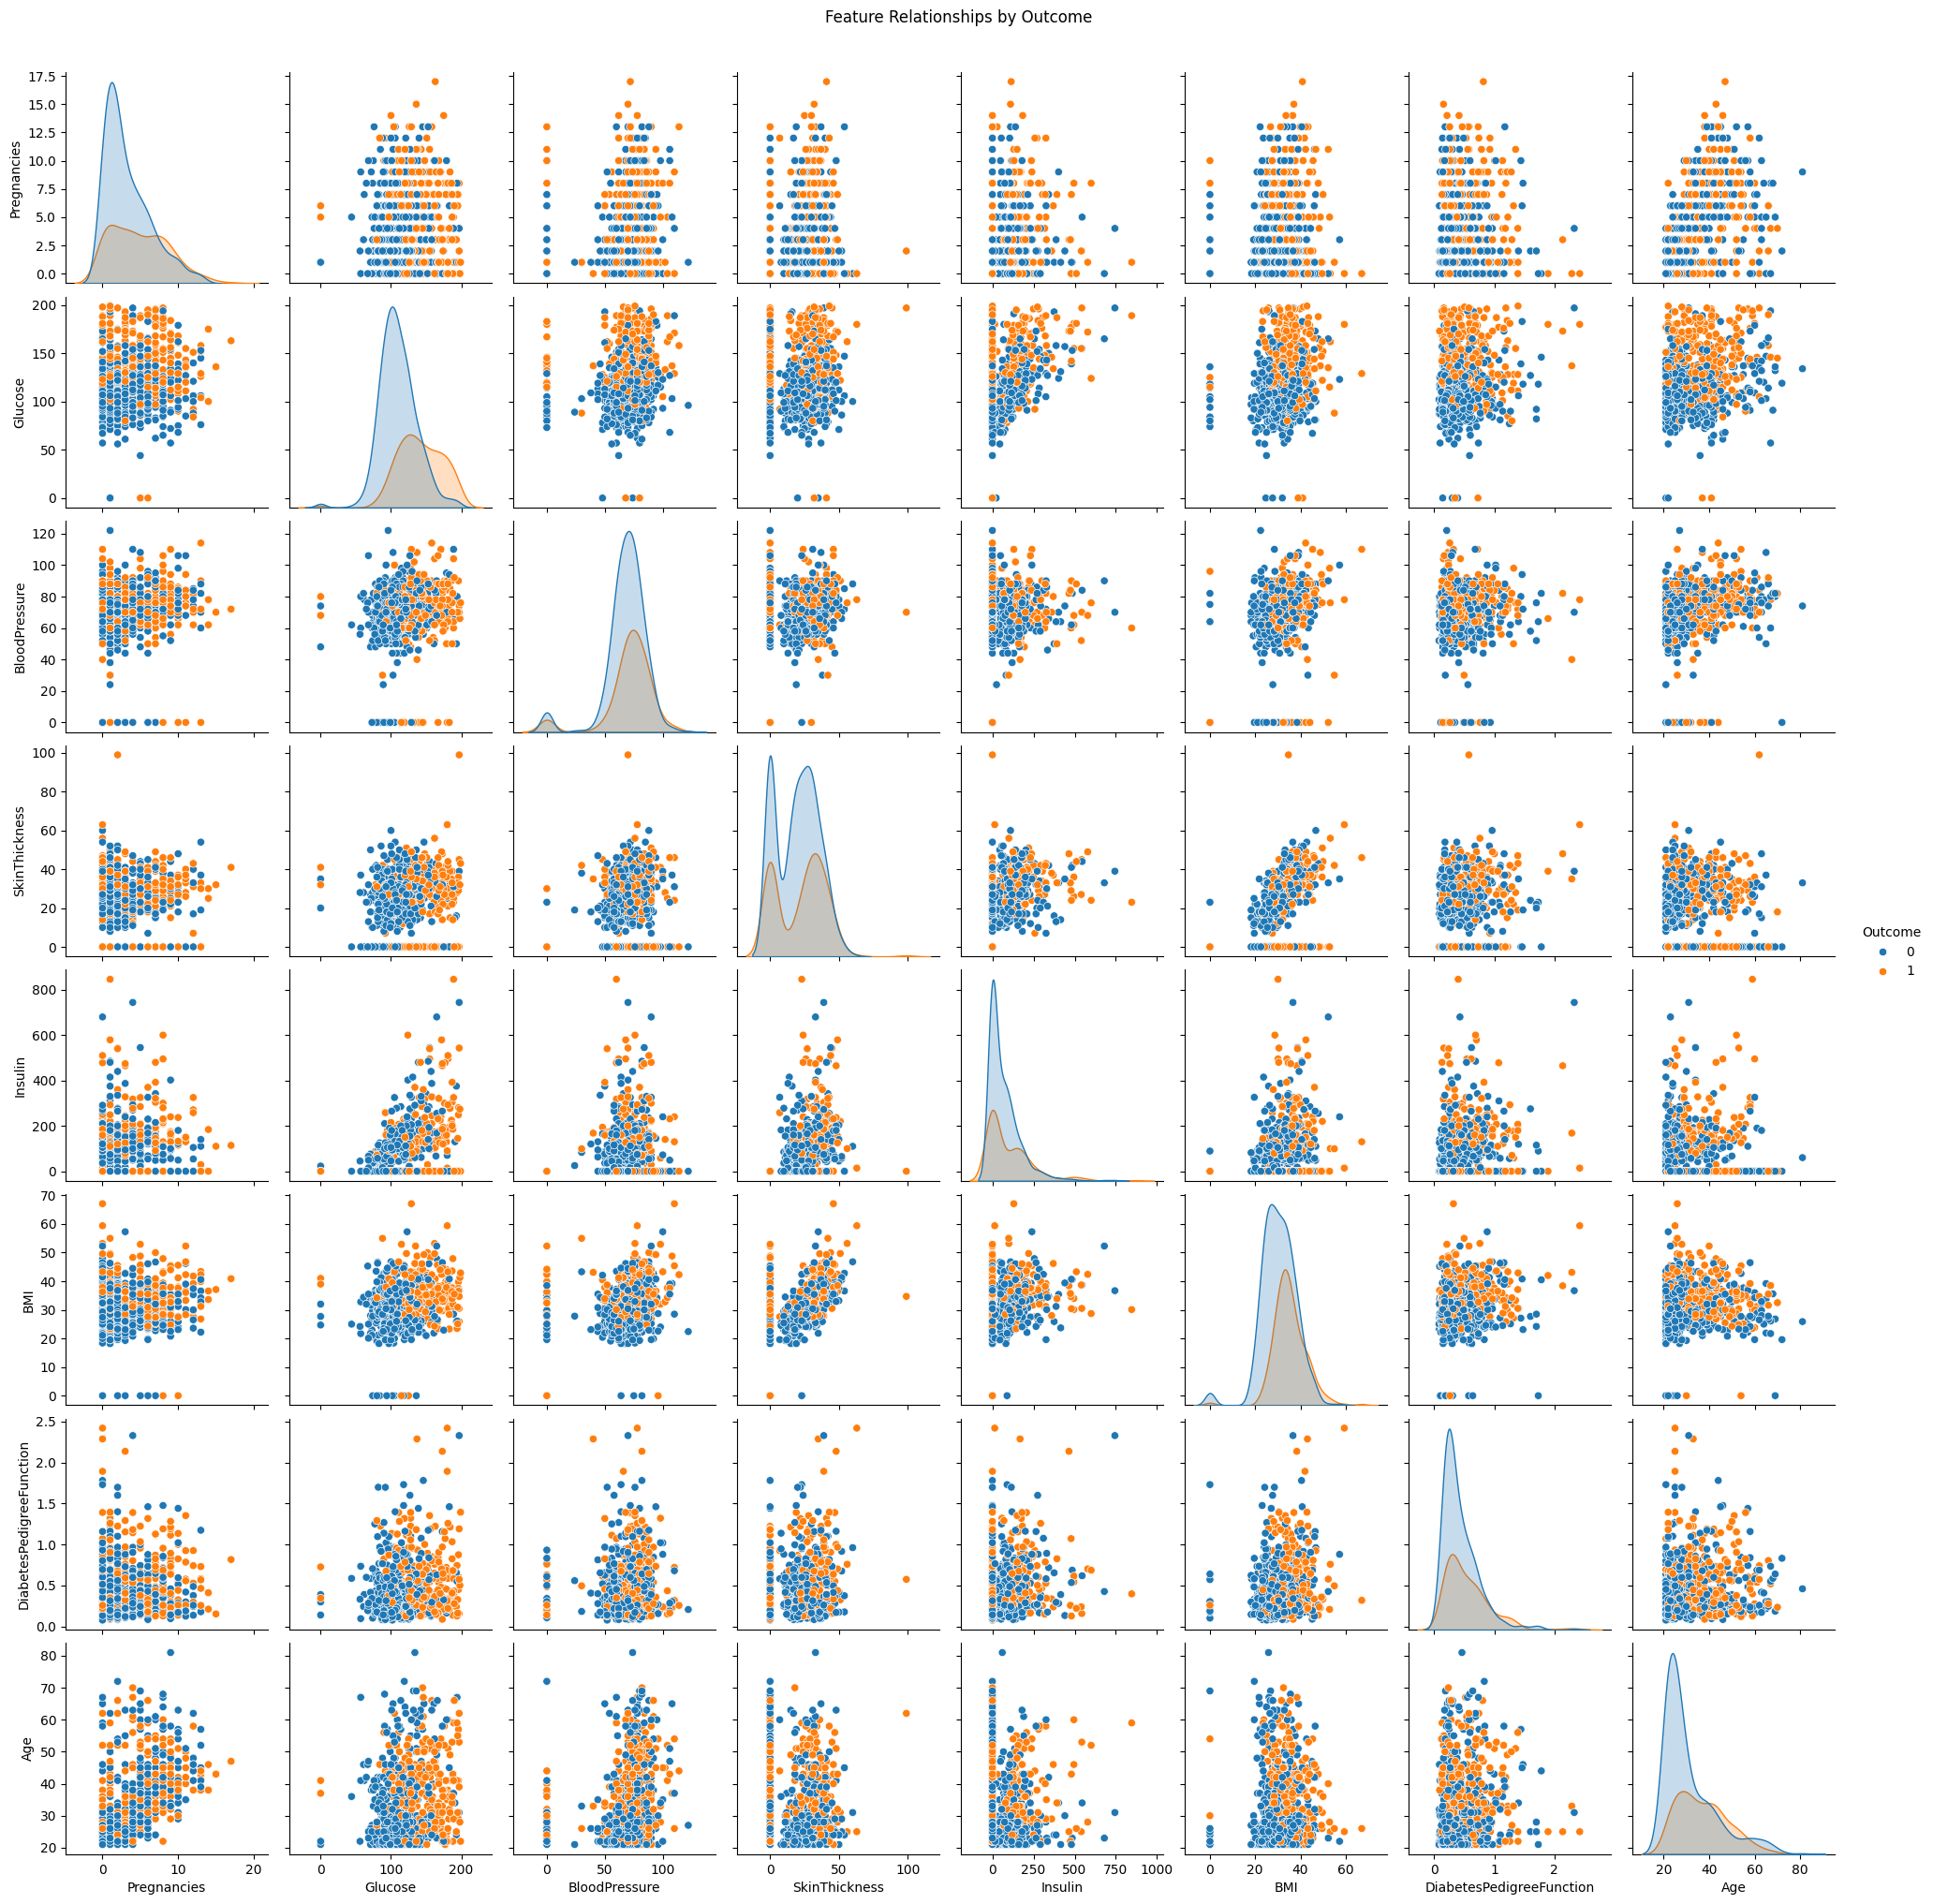

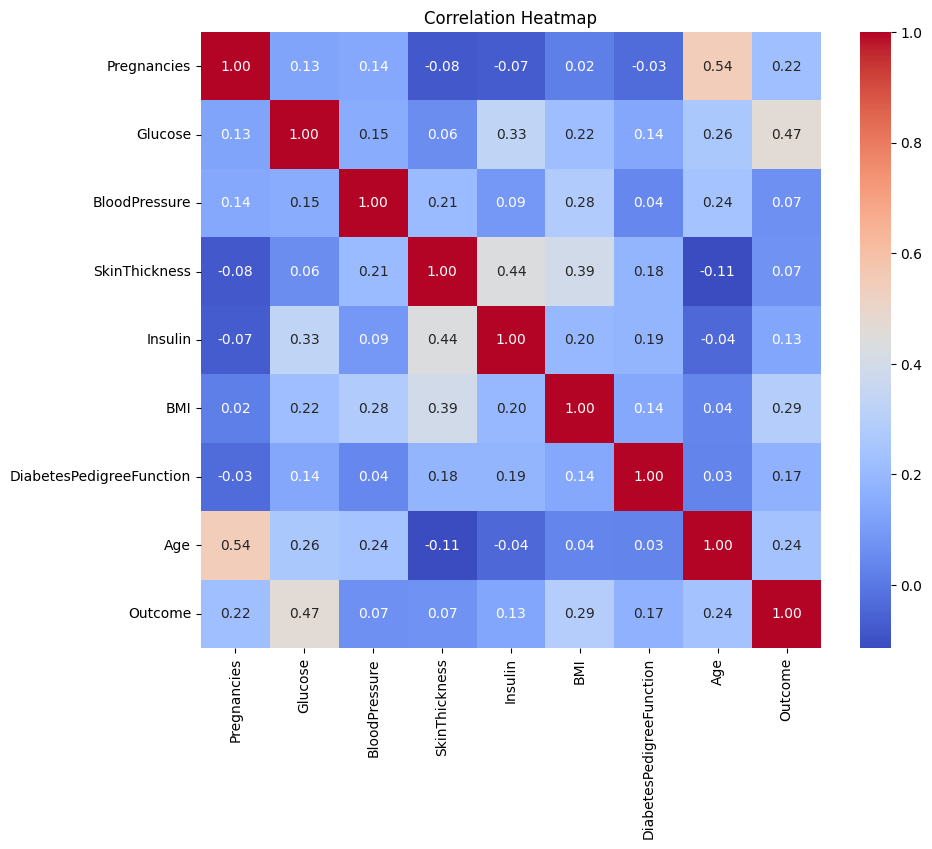

Best Perceptron Parameters: {'alpha': 0.001, 'eta0': 1.0, 'max_iter': 500, 'penalty': 'elasticnet', 'random_state': 42}
Accuracy: 0.7337662337662337
Confusion Matrix:
 [[71 29]
 [12 42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78       100
           1       0.59      0.78      0.67        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.76      0.73      0.74       154



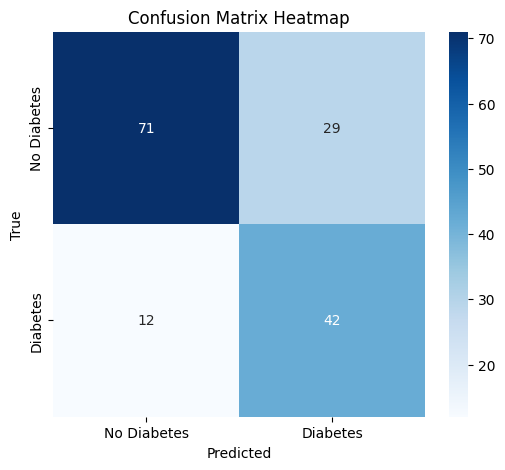

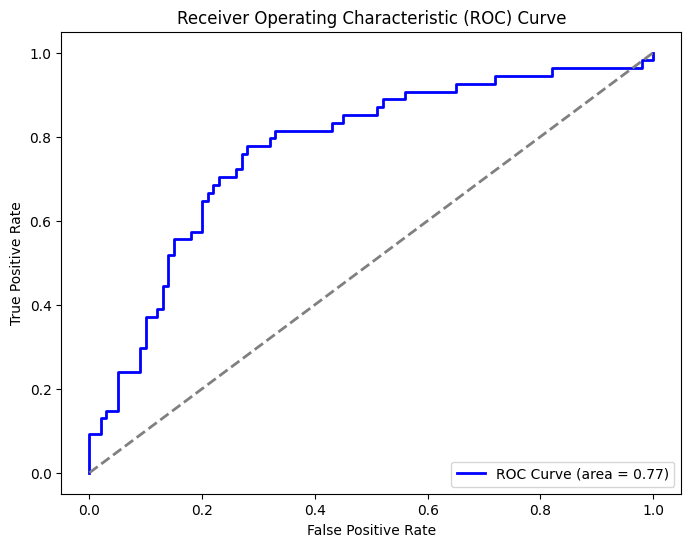

In [ ]:
# Pair Plot
sns.pairplot(diabetes_data, hue='Outcome')
plt.suptitle('Feature Relationships by Outcome', y=1.02)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(diabetes_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parameter grid
param_grid = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [500, 1000, 2000],
    'eta0': [0.01, 0.1, 1.0],
    'random_state': [42]
}

# Load perceptron model
perceptron = Perceptron()

# Find the best parameters
grid_search = GridSearchCV(perceptron, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and estimator
best_perceptron = grid_search.best_estimator_

# Train & make prediction
best_perceptron.fit(X_train_scaled, y_train)
y_pred = best_perceptron.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print("Best Perceptron Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# ROC curve
y_pred_prob = best_perceptron.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Fixing overfitting

Best Perceptron Parameters: {'penalty': 'l2', 'max_iter': 1000, 'eta0': 0.01, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.01}
Accuracy: 0.6428571428571429
Confusion Matrix:
 [[70 30]
 [25 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       100
           1       0.49      0.54      0.51        54

    accuracy                           0.64       154
   macro avg       0.61      0.62      0.62       154
weighted avg       0.65      0.64      0.65       154



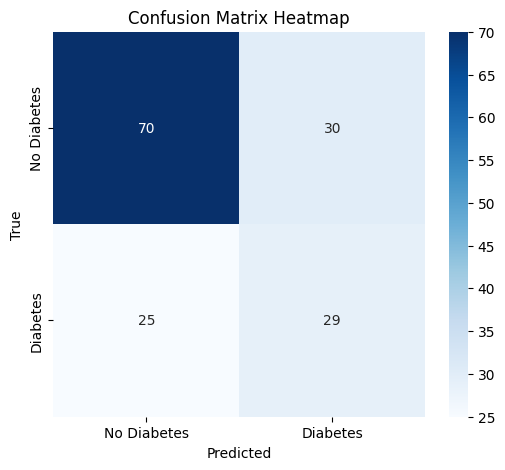

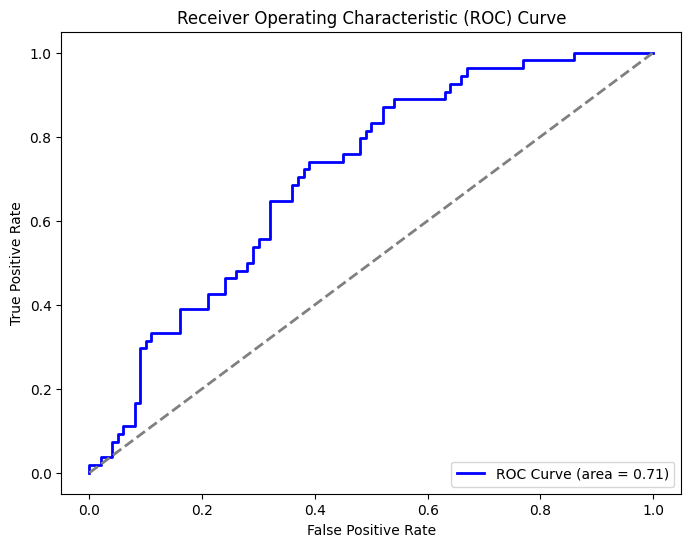

In [ ]:
# Feature selection using RFE
selector = RFE(estimator=Perceptron(), n_features_to_select=5, step=1)
X_selected = selector.fit_transform(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Feature standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Refined parameter grid with stronger regularisation
param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.01, 0.1, 0.2],
    'max_iter': [1000, 1500, 2000],
    'eta0': [0.01, 0.05],
    'early_stopping': [True],
    'class_weight': ['balanced']
}

# Initialise Perceptron and perform RandomizedSearchCV using stratified cross-validation
perceptron = Perceptron(random_state=42)
random_search = RandomizedSearchCV(perceptron, param_grid, scoring='accuracy', n_iter=15, cv=StratifiedKFold(5), n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Best Perceptron with updated tuning & train
best_perceptron = random_search.best_estimator_
best_perceptron.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_perceptron.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Best Perceptron Parameters:", random_search.best_params_)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# ROC curve
y_pred_prob = best_perceptron.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Fine-tuning model

Best Perceptron Parameters: {'alpha': 0.02, 'class_weight': 'balanced', 'early_stopping': True, 'eta0': 0.05, 'max_iter': 1500, 'n_iter_no_change': 10, 'penalty': 'l2', 'validation_fraction': 0.15}
Accuracy: 0.7207792207792207
Confusion Matrix:
 [[71 29]
 [14 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77       100
           1       0.58      0.74      0.65        54

    accuracy                           0.72       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.72      0.73       154



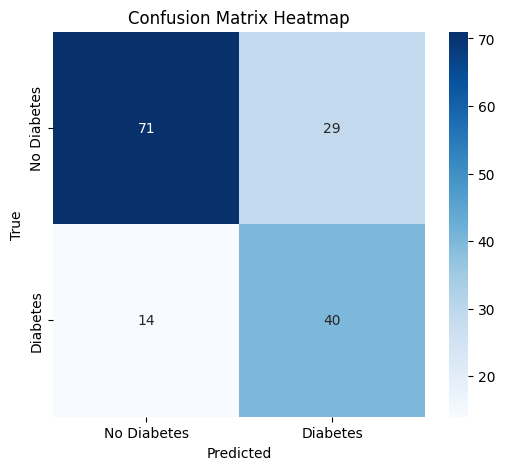

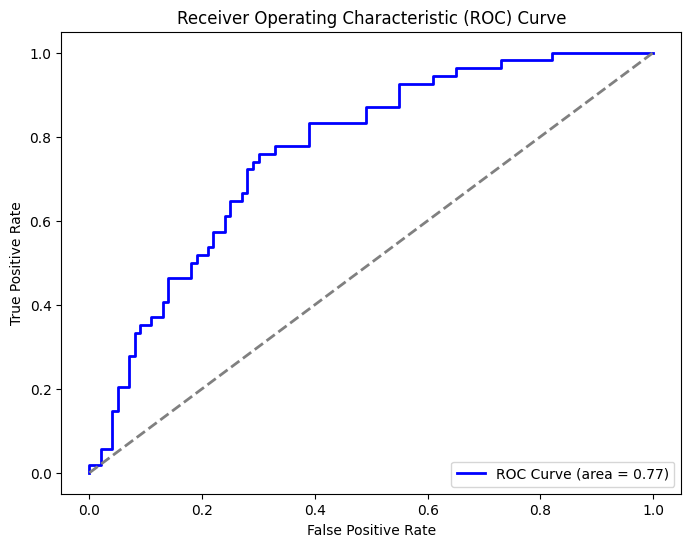

In [ ]:
# Feature selection using RFE
selector = RFE(estimator=Perceptron(), n_features_to_select=6, step=1)
X_selected = selector.fit_transform(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Feature standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parameter grid
param_grid = {
    'penalty': ['l2', 'elasticnet'],
    'alpha': [0.005, 0.01, 0.02],
    'max_iter': [1500, 2000, 2500],
    'eta0': [0.01, 0.05, 0.07],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.15],
    'n_iter_no_change': [5, 10],
    'class_weight': ['balanced']
}

# Perform GridSearchCV with stratified cross-validation
perceptron = Perceptron(random_state=42)
grid_search = GridSearchCV(perceptron, param_grid, scoring='accuracy', cv=StratifiedKFold(5), n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best Perceptron with updated tuning & train
best_perceptron = grid_search.best_estimator_
best_perceptron.fit(X_train_scaled, y_train)

y_pred = best_perceptron.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Best Perceptron Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# ROC curve
y_pred_prob = best_perceptron.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
